In [1]:
import os
import tarfile
import cv2
import numpy as np
import tarfile
import tempfile
from six.moves import urllib

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from matplotlib import pyplot as plt
from matplotlib import gridspec

#%matplotlib notebook

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
            
        input_shape = self.graph.get_tensor_by_name(self.INPUT_TENSOR_NAME).get_shape()
        print(input_shape)

        self.sess = tf.Session(graph=self.graph)
        
    def run(self, image, resize=None):
        # Resize
        if (resize != None):
            width, height, depth = image.shape
            resize_ratio = 1.0 * resize / max(width, height)
            target_size = (int(resize_ratio * height), int(resize_ratio * width))        
            resized_image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        else:
            resized_image = image
        
        # convert to RGB for inference.
        inference_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        # Run inference
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME,
                                      feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(inference_image)]})
        seg_map_pred = batch_seg_map[0]
        return resized_image, seg_map_pred
    
def create_pascal_label_colormap():
    colormap = np.zeros((256, 3), dtype=int)
    ind = np.arange(256, dtype=int)

    for shift in reversed(range(8)):
        for channel in range(3):
            colormap[:, channel] |= ((ind >> channel) & 1) << shift
        ind >>= 3

    return colormap   

def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_pascal_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

LABEL_NAMES = np.asarray([
    'road',
    'sidewalk',
    'building',
    'guard rail',
    'bridge',
    'pole',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'trailer',
    'motorcycle',
    'bicycle',
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def display (image, mask):
    unique_labels = np.unique(mask)
    color_mask = label_to_color_image(mask).astype(np.uint8)

    plt.figure(figsize=(15, 15))
    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 1])
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.imshow(color_mask, alpha=0.4)
    plt.axis('off')

    ax = plt.subplot(grid_spec[1])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


In [7]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'mobilenetv3_large_cityscapes_trainfine':
        'deeplab_mnv3_large_cityscapes_trainfine_2019_11_15.tar.gz',
    'mobilenetv3_small_cityscapes_trainfine':
        'deeplab_mnv3_small_cityscapes_trainfine_2019_11_15.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',    
    'xception71_dpc_cityscapes_trainfine':
        'deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz',
    'xception71_dpc_cityscapes_trainval':
        'deeplab_cityscapes_xception71_trainvalfine_2018_09_08.tar.gz',
    'EdgeTPU-DeepLab':
        'edgetpu-deeplab-slim_2020_03_09.tar.gz',
    'EdgeTPU-DeepLab-slim':
        'edgetpu-deeplab-slim_2020_03_09.tar.gz'
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')
model = DeepLabModel(download_path)

downloading model, this might take a while...
download completed! loading DeepLab model...
(1, ?, ?, 3)


In [8]:
#model = DeepLabModel('edge_deeplab_model.tar.gz')
#model = DeepLabModel('deeplab_model.tar.gz')

In [9]:
RESIZE_TO = None
image = cv2.imread('image_5.png', cv2.IMREAD_COLOR)
resized_image, seg_map = model.run(image, RESIZE_TO)

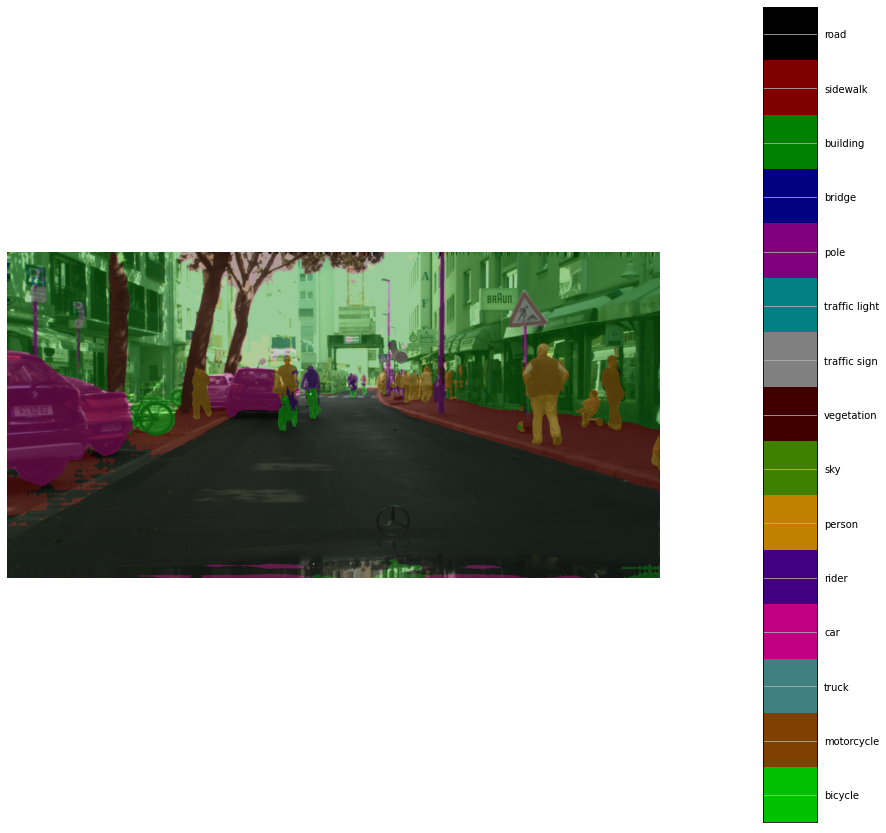

In [10]:
display(resized_image, seg_map)

Road = 0
Sidewalk = 1
Building = 2
Pole = 5
Traffic Light = 6
Sky = 10
Person = 11
Rider = 12
Car = 13
Bus = 15
Bike = 18

In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    # if frame is read correctly ret is True
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break

    # run inference, size down to 512 (seems to be a model requirement)
    image, seg_map = model.run(frame, 512)
    
    # Create color mask from segment map.
    color_mask = label_to_color_image(seg_map).astype(np.uint8)
    
    # Now blend the image with the mask    
    image = cv2.addWeighted(image, 0.6, color_mask, 0.4, 0.0)
    
    # Display the resulting frame
    cv2.imshow('frame', image)
    if cv2.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()